In [1]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats

## Inserez les chemins vers le fichiers CSV:

In [2]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
for x in contenuDossier:
    if x.startswith('point') :
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(numeroPoints)
numeroPoints.remove('15')
print(numeroPoints)

['point14_29_07_15', 'point15_29_07_15', '.DS_Store', 'schema_dispositif_AvAv_23_07_15.png', 'point47_27_08_19', 'point13_29_07_15', 'point36_12_07_16', 'point46_17_06_19', 'point34_27_06_16', 'point48_14_04_18']
['14', '15', '47', '13', '36', '46', '34', '48']
['14', '47', '13', '36', '46', '34', '48']


In [3]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [4]:
# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
data = []
for x in nomPoints :
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:4]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))
    # on va ensuite mettre les dataframes dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if (x.startswith('p') and x.endswith('.csv')) and not x.endswith('cleaned.csv') :
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va chercher les données
    chemin_etalonnage = 'configuration/pressure_sensors/P' + dico['capteur'][1:] +'.csv'
    if os.path.exists(chemin_etalonnage):
        with open(chemin_etalonnage) as fichier :
            lignes = fichier.readlines()
            for l in lignes :
                if l.startswith('Intercept') :
                    dico['intercept'] = float(l[10:-2])
                if l.startswith('dU/dH') :
                    dico['dU/dH'] = float(l[6:-2])
                if l.startswith('dU/dT') :
                    dico['dU/dT'] = float(l[6:-2]) 
    data.append(dico)


In [5]:

data[5]['pression']['Date Heure, GMT+01:00'].is_monotonic_increasing
#data[5]['numero']

False

In [6]:
# en faisant data[0] on a accès à toutes les informations du point 1
data[0]

{'numero': '14',
 'nom': 'point14_29_07_15',
 'date': '29_07_15',
 'chemin': './raw_data/point14_29_07_15',
 'capteur': 'p507',
 'profondeur': 0,
 'profondeurMesures': [10, 20, 30, 40],
 'pression':        #  Date Heure GMT+02:00  \
 0      1  07/23/15 02:00:00 PM   
 1      2  07/23/15 02:15:00 PM   
 2      3  07/23/15 02:30:00 PM   
 3      4  07/23/15 02:45:00 PM   
 4      5  07/23/15 03:00:00 PM   
 ..   ...                   ...   
 558  559  07/29/15 09:30:00 AM   
 559  560  07/29/15 09:45:00 AM   
 560  561  07/29/15 10:00:00 AM   
 561  562  07/29/15 10:15:00 AM   
 562  563  07/29/15 10:30:00 AM   
 
      Tension V (LGR S/N: 10614065 SEN S/N: 10614065)  \
 0                                            0.01183   
 1                                            0.00080   
 2                                            0.00080   
 3                                            0.00092   
 4                                            0.00088   
 ..                                   

# Est ce que les fichiers peuvent être utilisés ?

**Dans notre cas, nous prendrons ces solutions**

* S'il manque toutes les données du capteurs de pression ou l'étalonnage, nous déciderons que ce point est invalide.
* S'il manque une partie des données nous vérifierons que nous avons au mimimun 7 jours de données
* S'il manque plus de 2 capteurs de température, nous déciderons que ce point est invalide.

### Est ce que nous avons les données de l'étalonnage du capteur ?

In [7]:
for x in data :
    if not 'intercept' in x.keys() :
        print('le point '+ x['numero'] + ' n\'a pas d\'étalonnage, il n\'est pas valide')
        data.remove(x)

### Est ce que nous avons des données pour le capteur de pression ?

In [8]:
for x in data :
    if x['pression'].empty :
        print('le point '+ x['numero'] + ' n\'a pas de données de pression, il n\'est pas valide')
        data.remove(x)

In [9]:
data[6]['pression']

,#,"Date Heure, GMT+01:00","Tension, V (LGR S/N: 10831978, SEN S/N: 10831978, LBL: dh)","Temp., °C (LGR S/N: 10831978, SEN S/N: 10831978, LBL: T°C)",Hôte connecté (LGR S/N: 10831978),Arrêté (LGR S/N: 10831978),Fin de fichier (LGR S/N: 10831978)
0,1.0,06/27/16 12:00:00 PM,1.26787,18.342,NaN,NaN,NaN
1,2.0,06/27/16 12:15:00 PM,1.06630,13.898,NaN,NaN,NaN
2,3.0,06/27/16 12:30:00 PM,1.20661,13.915,NaN,NaN,NaN
3,4.0,06/27/16 12:45:00 PM,1.24533,13.939,NaN,NaN,NaN
4,5.0,06/27/16 01:00:00 PM,1.24437,13.967,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1455,1447.0,07/12/2016 15:45,1.13668,9.126,NaN,NaN,NaN
1456,1447.7,07/12/2016 16:00,1.33513,9.157,NaN,NaN,NaN
1457,1448.4,07/12/2016 16:15,1.38926,9.199,NaN,NaN,NaN
1458,1449.1,07/12/2016 16:30,1.41386,9.244,NaN,NaN,NaN


### On modifie les nom des colonnes du dataframe

In [10]:
# pour les températures
for x in data :
    # on supprime les colonnes qui ne servent à rien
    for i in x['temperature'].columns :
        if not( i.startswith(('Date', 'dates', 'temp','Temp'))) :
            del x['temperature'][i]
    for i in x['pression'].columns :
        if not( i.startswith(('Date', 'dates', 'Tension', 'tension', 'pressure', 'temp', 'Temp'))) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    x['temperature'].columns = colonnesT
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP
    

In [11]:
# notamment la température et la pression
data[0]['temperature'].head(5)

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,07/23/15 02:00:00 PM,26.207,27.554,26.378,28.097
1,07/23/15 02:15:00 PM,28.147,27.087,26.867,29.265
2,07/23/15 02:30:00 PM,28.419,28.543,27.431,29.615
3,07/23/15 02:45:00 PM,18.390,21.223,18.319,19.555
4,07/23/15 03:00:00 PM,18.509,21.318,18.461,19.413


## Conversion de valeurs de tension a differance de charge

In [12]:
for point in data:
    k0 = float(point['intercept'])
    k1 = float(point['dU/dH'])
    k2 = float(point['dU/dT'])
    
    # Calcul de la colonne 'dH' en utilisant la formule H = 1/k1 * (U - k0 - k2 * T)
    U = point['pression']['tension'].astype(float)
    T = point['pression']['temperature_stream'].astype(float)
    point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

data[0]['pression']

,dates,tension,temperature_stream,dH
0,07/23/15 02:00:00 PM,0.01183,45.230,0.183945
1,07/23/15 02:15:00 PM,0.00080,21.979,0.104472
2,07/23/15 02:30:00 PM,0.00080,21.609,0.103194
3,07/23/15 02:45:00 PM,0.00092,21.910,0.104225
4,07/23/15 03:00:00 PM,0.00088,20.966,0.100966
...,...,...,...,...
558,07/29/15 09:30:00 AM,1.23991,15.562,-0.014592
559,07/29/15 09:45:00 AM,1.23709,15.541,-0.014444
560,07/29/15 10:00:00 AM,1.24273,15.513,-0.014982
561,07/29/15 10:15:00 AM,1.24022,15.599,-0.014488


### On enlève les valeurs Nan

In [13]:
for x in data :
    x['temperature'] = x['temperature'].dropna(axis = 0, how = 'any')
    x['pression'] = x['pression'].dropna(axis = 0, how='any')

In [14]:
from dateutil import parser

# Conversion dans le bon format date
for x in data:
    x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
    x['temperature']['dates'] = x['temperature']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
#    point['pression']['dates'] = pd.to_datetime(point['pression']['dates'], format='mixed')
#    point['temperature']['dates'] = pd.to_datetime(point['temperature']['dates'], format='mixed')

In [15]:
data[0]['pression'].head(5)

,dates,tension,temperature_stream,dH
0,23-07-2015 14:00,0.01183,45.230,0.183945
1,23-07-2015 14:15,0.00080,21.979,0.104472
2,23-07-2015 14:30,0.00080,21.609,0.103194
3,23-07-2015 14:45,0.00092,21.910,0.104225
4,23-07-2015 15:00,0.00088,20.966,0.100966


In [16]:
for x in data :
    # Traiter chaque colonne sauf la colonne des dates
    columns_to_processP = [col for col in x['pression'].columns if col != 'dates']
    columns_to_processT = [col for col in x['temperature'].columns if col != 'dates']
    # Créer un DataFrame vide pour stocker les données traitées
    x['pression2'] = x['pression'][['dates']].copy()
    x['temperature2'] = x['temperature'][['dates']].copy()
    # Boucler à travers chaque colonne à traiter
    for column_name in columns_to_processP :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['pression'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['pression'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['pression2'][column_name] = df_cleaned[column_name]
    # pareil pour les températures
    for column_name in columns_to_processT :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['temperature'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['temperature'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['temperature2'][column_name] = df_cleaned[column_name]

In [17]:
for x in data :
    x['temperature2'] = x['temperature2'].dropna(axis = 0, how = 'any')
    x['pression2'] = x['pression2'].dropna(axis = 0, how='any')

In [18]:
# on met à jour la date de début de la mesure, la date de fin et la période
from datetime import datetime

for x in data :
    x['dateDebut'] = datetime.strptime(x['pression2']['dates'].iloc[0], '%d-%m-%Y %H:%M')
    x['dateFin'] = datetime.strptime(x['pression2']['dates'].iloc[x['pression2']['dates'].shape[0]-1], '%d-%m-%Y %H:%M')
    x['periode'] = x['dateFin'] - x['dateDebut']

### Est ce que nous avons au minimum 3 jours de données ?

In [19]:
for x in data :
    if x['periode'].days <= 3 :
        print('le point ' + x['numero'] + ' n\'est pas valide car sa période est de seulement ' + str(x['periode'])[0] +' jours')
        data.remove(x)

le point 15 n'est pas valide car sa période est de seulement 2 jours


### Création du fichier `info.txt`

In [20]:
# Ouvrez un fichier en mode écriture ('w')
for x in data :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_info.txt') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_info.txt')
    with open(x['chemin'] + '/point' + x['numero'] + '_info.txt', 'w') as fichier:
        # Parcourez le dictionnaire et écrivez les données dans le fichier
        fichier.write('Point_Name,Point' + x['numero'] + '\n')
        fichier.write('P_Sensor_Name,' + x['capteur'] + '\n')
        fichier.write('Implantation_Date,' + x['date'] + '\n')
        fichier.write('Meas_date,' + str(x['dateDebut']) + '\n')
        fichier.write('River_Deb,' '\n') 
        fichier.write('Delta_h,' + '\n')
        fichier.write('Periode,' + str(x['periode']) + '\n')

In [21]:
data[0]['temperature2']

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
6,23-07-2015 15:30,17.938,20.650,17.748,19.199
7,23-07-2015 15:45,17.867,20.460,17.677,19.056
8,23-07-2015 16:00,17.843,20.579,17.629,19.246
9,23-07-2015 16:15,17.819,20.627,17.605,19.389
16,23-07-2015 18:00,17.772,20.603,17.534,17.701
...,...,...,...,...,...
558,29-07-2015 09:30,15.986,15.772,15.867,14.649
559,29-07-2015 09:45,15.986,15.772,15.867,14.625
560,29-07-2015 10:00,15.986,15.724,15.867,14.577
561,29-07-2015 10:15,15.986,15.748,15.867,14.745


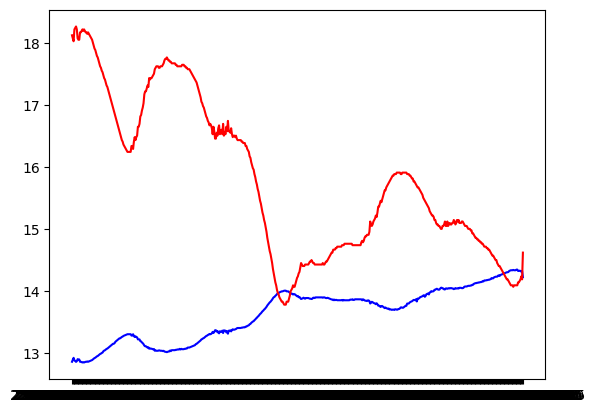

In [22]:
i = 2
plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['dH']*150, color = 'blue')
plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['temperature_stream'], color = 'red')

In [23]:
data[i]['pression']['dates'].is_monotonic_increasing

True

# Traitement des signaux de temperature et pression

### Evaluer la correlation entre les signaux pour chaque point

In [24]:

# Générer deux signaux synthétiques de température et de pression (ou charger vos données réelles)
# Assurez-vous que les signaux ont la même longueur
list_point_correlation = []
for point in data:
    print(f"point {point['numero']}")
    temperature_signal = point['pression2']['temperature_stream']
    pressure_signal = point['pression2']['dH']


    # Calculer la corrélation entre les deux signaux
    correlation = np.corrcoef(temperature_signal, pressure_signal)[0, 1]

    # Afficher la corrélation
    print(f"Corrélation entre température et pression : {correlation:.2f}")

    # Interprétation de la corrélation
    if correlation > 0:
        print("Corrélation positive : Les signaux sont corrélés positivement.")
    elif correlation < 0:
        print("Corrélation négative : Les signaux sont corrélés négativement.")
    else:
        print("Corrélation nulle : Aucune corrélation linéaire entre les signaux.")

    # Vous pouvez également calculer le coefficient de détermination (R²) pour évaluer la force de la corrélation.
    r_squared = correlation**2
    if r_squared > 0.8: 
        list_point_correlation.append(point['numero'])
    print(f"Coefficient de détermination (R²) : {r_squared:.2f}") 

print(list_point_correlation)




point 14
Corrélation entre température et pression : 0.44
Corrélation positive : Les signaux sont corrélés positivement.
Coefficient de détermination (R²) : 0.20
point 47
Corrélation entre température et pression : 0.64
Corrélation positive : Les signaux sont corrélés positivement.
Coefficient de détermination (R²) : 0.40
point 13
Corrélation entre température et pression : -0.95
Corrélation négative : Les signaux sont corrélés négativement.
Coefficient de détermination (R²) : 0.89
point 36
Corrélation entre température et pression : 0.40
Corrélation positive : Les signaux sont corrélés positivement.
Coefficient de détermination (R²) : 0.16
point 46
Corrélation entre température et pression : -0.63
Corrélation négative : Les signaux sont corrélés négativement.
Coefficient de détermination (R²) : 0.39
point 34
Corrélation entre température et pression : -0.28
Corrélation négative : Les signaux sont corrélés négativement.
Coefficient de détermination (R²) : 0.08
point 48
Corrélation entr

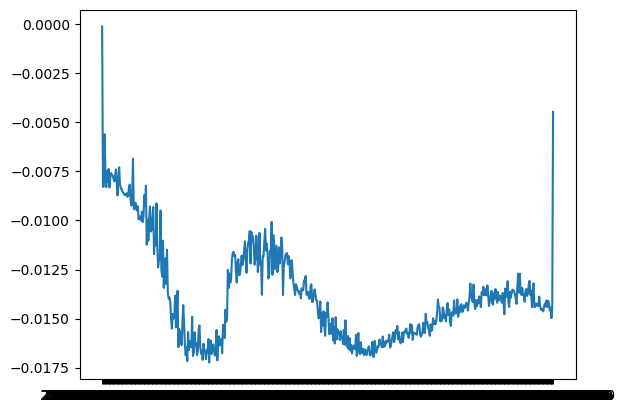

In [25]:
plt.plot(data[0]['pression2']['dates'], data[0]['pression2']['dH'])

In [26]:
data[0]['pression2'].drop(data[0]['pression2'].head(1).index,inplace=True)
data[0]['pression2'].drop(data[0]['pression2'].tail(1).index,inplace=True)

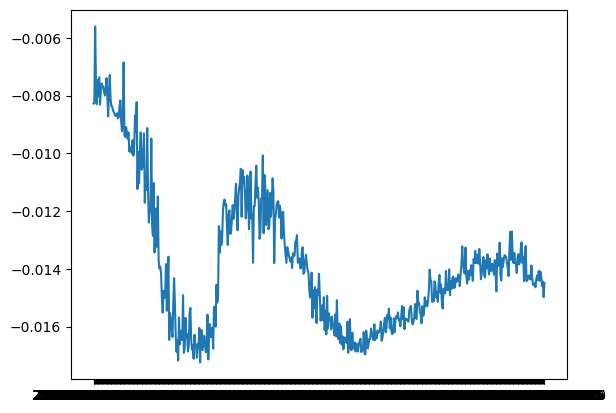

In [27]:
plt.plot(data[0]['pression2']['dates'], data[0]['pression2']['dH'])

In [ ]:
plt.plot(data[0]['']['dates'], data[0][''][''])

### FFT


In [28]:
for i in list_point_correlation:
    K=numeroPoints.index(i)
    print(K)

2


In [29]:
print(data[K])

{'numero': '13', 'nom': 'point13_29_07_15', 'date': '29_07_15', 'chemin': './raw_data/point13_29_07_15', 'capteur': 'p505', 'profondeur': 0, 'profondeurMesures': [10, 20, 30, 40], 'pression':                 dates  tension  temperature_stream        dH
0    23-07-2015 14:00  0.58181              18.129  0.085770
1    23-07-2015 14:15  0.58059              18.081  0.085981
2    23-07-2015 14:30  0.57937              18.033  0.086192
3    23-07-2015 14:45  0.57937              18.224  0.085898
4    23-07-2015 15:00  0.57937              18.247  0.085863
..                ...      ...                 ...       ...
558  29-07-2015 09:30  0.54884              14.194  0.095526
559  29-07-2015 09:45  0.54884              14.242  0.095452
560  29-07-2015 10:00  0.54884              14.194  0.095526
561  29-07-2015 10:15  0.54884              14.625  0.094863
562  29-07-2015 10:30  0.55189              28.617  0.073004

[563 rows x 4 columns], 'temperature':                 dates  Temp_profonde

In [30]:
T_s_C = data[K]['pression2'][['temperature_stream','dates']]
print(T_s_C)
data_sample=np.array(T_s_C['temperature_stream'])
data_abscisses=np.array(T_s_C['dates'])

     temperature_stream             dates
0                18.129  23-07-2015 14:00
1                18.081  23-07-2015 14:15
2                18.033  23-07-2015 14:30
3                18.224  23-07-2015 14:45
4                18.247  23-07-2015 15:00
..                  ...               ...
557              14.170  29-07-2015 09:15
558              14.194  29-07-2015 09:30
559              14.242  29-07-2015 09:45
560              14.194  29-07-2015 10:00
561              14.625  29-07-2015 10:15

[562 rows x 2 columns]


In [31]:
d_H = data[K]['pression2'][['dH','dates']]
print(d_H)
data_sample_dH=np.array(d_H['dH'])
data_abscisses_dH=np.array(d_H['dates'])

           dH             dates
0    0.085770  23-07-2015 14:00
1    0.085981  23-07-2015 14:15
2    0.086192  23-07-2015 14:30
3    0.085898  23-07-2015 14:45
4    0.085863  23-07-2015 15:00
..        ...               ...
557  0.095563  29-07-2015 09:15
558  0.095526  29-07-2015 09:30
559  0.095452  29-07-2015 09:45
560  0.095526  29-07-2015 10:00
561  0.094863  29-07-2015 10:15

[562 rows x 2 columns]


In [32]:
correlation = np.corrcoef(data_sample, data_sample_dH)[0, 1]

# Afficher la corrélation
print(f"Corrélation entre température et pression : {correlation:.2f}")
r_squared = correlation**2
print(f"Coefficient de détermination (R²) : {r_squared:.2f}") 

Corrélation entre température et pression : -0.95
Coefficient de détermination (R²) : 0.89


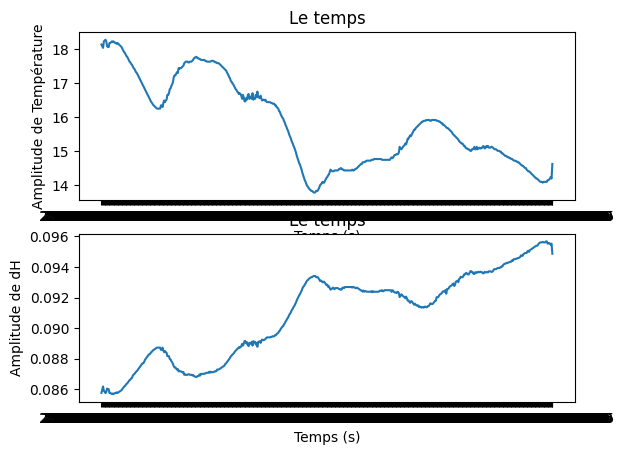

In [65]:
# from scipy import signal

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq, ifft

sample_rate=1/(15*60)


# Calculer la transformée de Fourier du signal audio
fft_result_T = fft(data_sample)
frequencies_T = fftfreq(len(fft_result_T), 1/sample_rate)

fft_result_dH = fft(data_sample_dH)
frequencies_dH = fftfreq(len(fft_result_dH), 1/sample_rate)


#print(len(fft_result_dH))

# Afficher le signal dans le domaine temporel
plt.subplot(2, 1, 1)
plt.plot(data_abscisses, data_sample)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude de Température")
plt.title("Le temps")

# Afficher le signal dans le domaine temporel
plt.subplot(2, 1, 2)
plt.plot(data_abscisses_dH, data_sample_dH)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude de dH")
plt.title("Le temps")
plt.show()




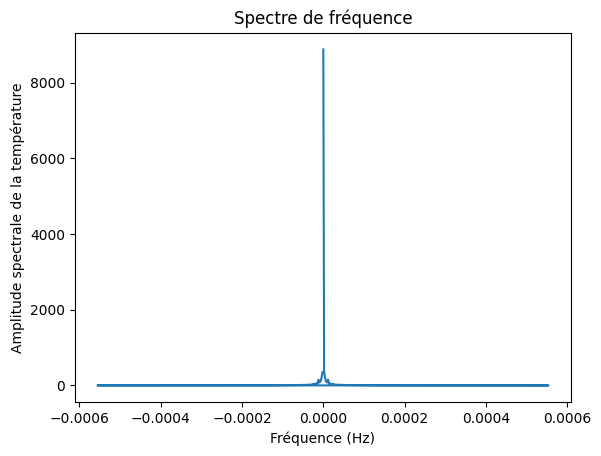

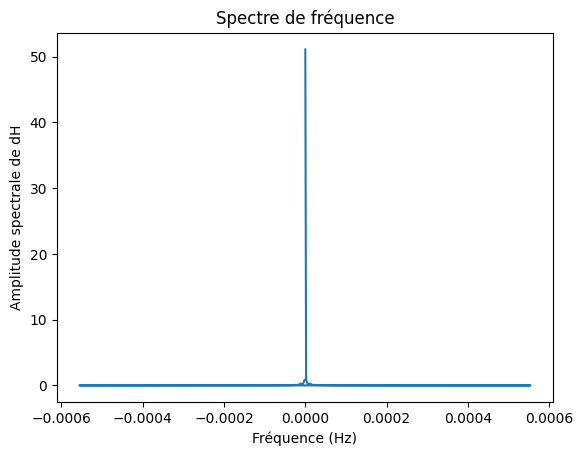

In [66]:
# Afficher le spectre de fréquence dans le domaine fréquentiel mask

plt.plot(frequencies_T, np.abs(fft_result_T))
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude spectrale de la température")
plt.title("Spectre de fréquence")
plt.show()

# Afficher le spectre de fréquence dans le domaine fréquentiel mask_dH
plt.plot(frequencies_dH,np.abs(fft_result_dH))
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude spectrale de dH")
plt.title("Spectre de fréquence")
plt.show()

In [68]:
#selection des fréquences entre -0,05Hz et 0,05 Hz:
w=0.0002
mask = np.where((frequencies_T > -w) & (frequencies_T < w), True, False)
mask[0]=False

mask_dH = np.where((frequencies_dH > -w) & (frequencies_dH < w), True, False)
mask_dH[0]=False


# Trouver les pics dans le spectre des fréquences (peaks)
peaks_T, _T = find_peaks(np.abs(fft_result_T[mask]), height=75)
peaks_dH, _dH = find_peaks(np.abs(200*fft_result_dH[mask_dH]), height=0.1)

#print(peaks_T)
interval_peaks_half =[]
for i in peaks_T:
    if i < len(mask)//2 :
        interval_peaks_half.append(i) 

for i in peaks_T:
    l=-1
    j=1
    while np.abs(fft_result_T[i+j]) > 75  and i+j<len(mask):
        interval_peaks_half.append(i+j)
        j+=1
    while np.abs(fft_result_T[i+l]) > 75  and i+l>0:
        interval_peaks_half.append(i+l)
        l-=1  




# Convertissez les listes en ensembles (sets)
#ensemble1 = set(peaks_T)
#ensemble2 = set(peaks_dH)

# Trouvez les nombres communs en utilisant l'opération d'intersection d'ensembles
#nombres_communs = ensemble1.intersection(ensemble2)

# Convertissez le résultat en liste si nécessaire
#nombres_communs_liste = list(nombres_communs)

# Affichez les nombres communs
#print("Nombres communs :", nombres_communs_liste)
# print(peaks_T,peaks_dH)
# print(_T,_dH)

[5, 196, 6, 4, 3, 2, 1, 557, 366, 556, 558, 559, 560, 561]


In [77]:
for i in interval_peaks_half:
    if np.abs(1/(frequencies_T[i]*60*60*24))>3 or np.abs(1/(frequencies_T[i]*60*60*24))<0.4:
        interval_peaks_half.remove(i)
print(interval_peaks_half)


[5, 6, 4, 3, 2]


In [78]:
interval_peaks=list(interval_peaks_half)
for i in interval_peaks_half:
    interval_peaks.append(len(mask)-i)
print(interval_peaks)

[5, 6, 4, 3, 2, 557, 556, 558, 559, 560]


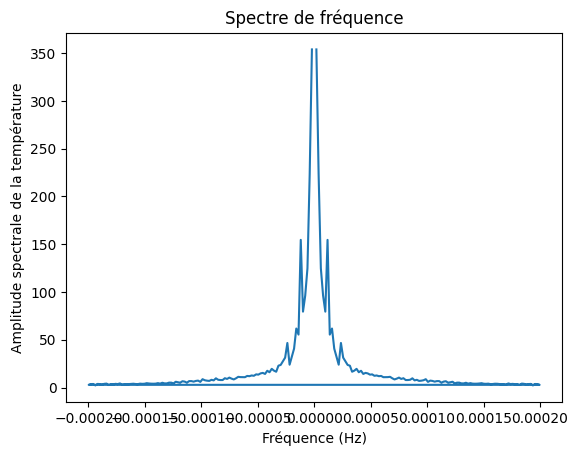

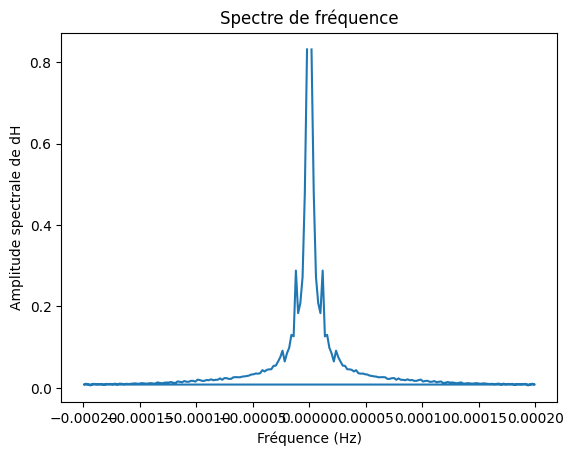

In [79]:
# Afficher le spectre de fréquence dans le domaine fréquentiel mask

plt.plot(frequencies_T[mask], np.abs(fft_result_T[mask]))
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude spectrale de la température")
plt.title("Spectre de fréquence")
plt.show()

# Afficher le spectre de fréquence dans le domaine fréquentiel mask_dH
plt.plot(frequencies_dH[mask_dH],np.abs(fft_result_dH[mask_dH]))
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude spectrale de dH")
plt.title("Spectre de fréquence")
plt.show()

In [80]:

#copie du signal fft_result_dH
fft_result_dH_copy=fft_result_dH.copy()

#on met à 0 les fréquences qui ne sont pas dans le masque
for i in interval_peaks:
        fft_result_dH_copy[i]=0


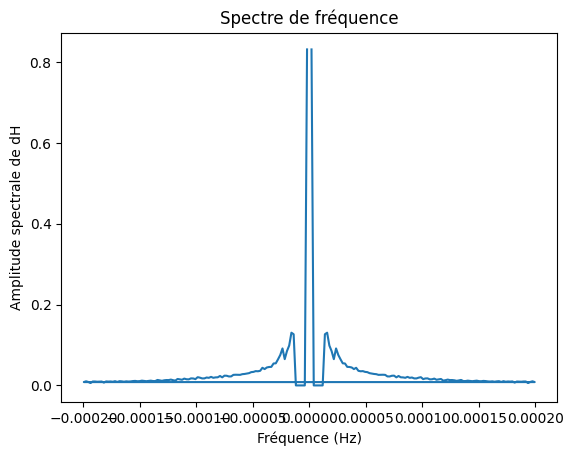

In [81]:
plt.plot(frequencies_dH[mask_dH],np.abs(fft_result_dH_copy[mask_dH]))
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude spectrale de dH")
plt.title("Spectre de fréquence")
plt.show()

In [82]:
#copie du signal fft_result_dH
#fft_result_dH_copy=fft_result_dH.copy()
#print(fft_result_dH_copy[0])
#on met à 0 les fréquences qui ne sont pas dans le masque
#for i in range(len(mask_dH)):
 #   if mask_dH[i]:
        #print(fft_result_dH_copy[i])
  #      fft_result_dH_copy[i]=(0+0j)
   #     print(fft_result_dH_copy[i],fft_result_dH[i])

/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


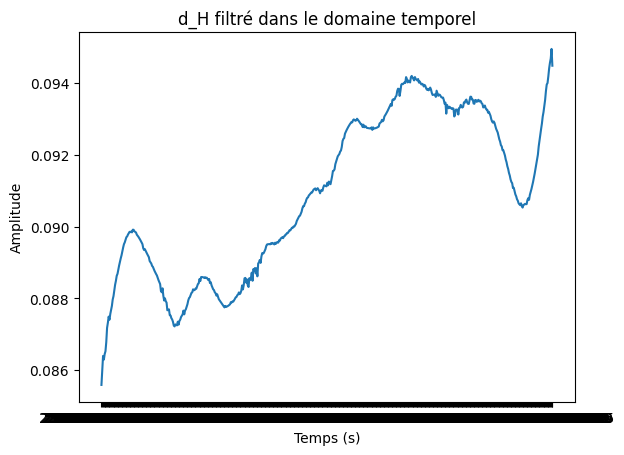

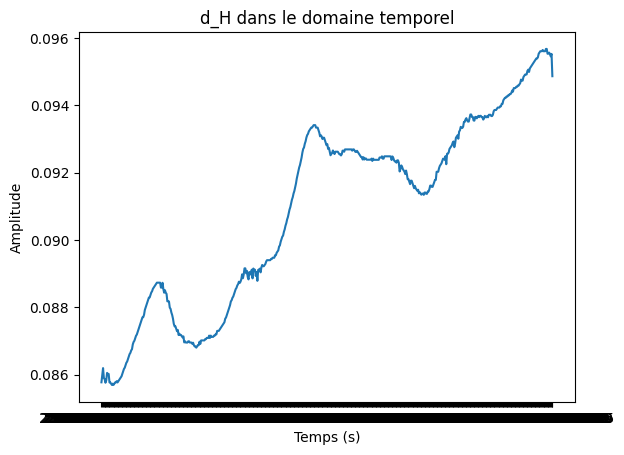

In [84]:
#on reconstruit le signal     
signal_reconstruit_dH = ifft(fft_result_dH_copy)

#afficher signal reconstruit
plt.plot(data_abscisses_dH, signal_reconstruit_dH)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title("d_H filtré dans le domaine temporel")
plt.show()

plt.plot(data_abscisses_dH, data_sample_dH)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title("d_H dans le domaine temporel")
plt.show()

In [85]:
correlation = np.corrcoef(data_sample, data_sample_dH)[0, 1]

 # Afficher la corrélation
print(f"Corrélation entre température et pression : {correlation:.2f}")

# Vous pouvez également calculer le coefficient de détermination (R²) pour évaluer la force de la corrélation.
r_squared = correlation**2
print(f"Coefficient de détermination (R²) : {r_squared:.2f}") 

Corrélation entre température et pression : -0.95
Coefficient de détermination (R²) : 0.89


In [86]:
correlation = np.corrcoef(data_sample, signal_reconstruit_dH)[0, 1]

 # Afficher la corrélation
print(f"Corrélation entre température et pression : {correlation:.2f}")

# Vous pouvez également calculer le coefficient de détermination (R²) pour évaluer la force de la corrélation.
r_squared = correlation**2
print(f"Coefficient de détermination (R²) : {r_squared:.2f}") 

Corrélation entre température et pression : -0.73+0.00j
Coefficient de détermination (R²) : 0.53-0.00j


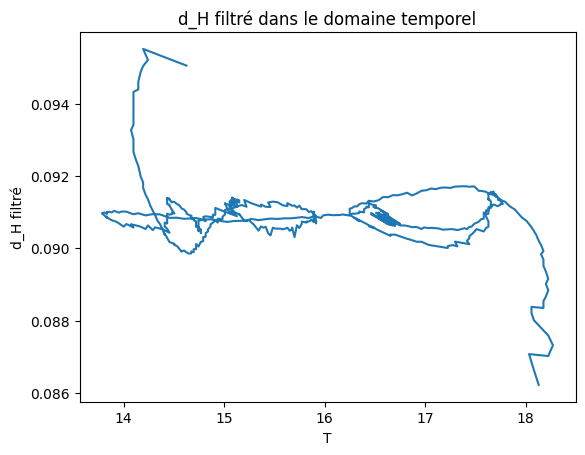

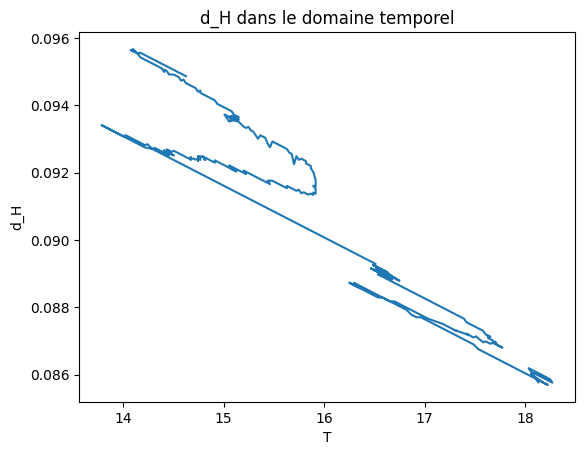

In [44]:
plt.plot(data_sample, signal_reconstruit_dH)
plt.xlabel("T")
plt.ylabel("d_H filtré")
plt.title("d_H filtré dans le domaine temporel")
plt.show()

plt.plot(data_sample, data_sample_dH)
plt.xlabel("T")
plt.ylabel("d_H")
plt.title("d_H dans le domaine temporel")
plt.show()

In [89]:
def traitement(k,data):
    T_s_C = data[k]['pression2'][['temperature_stream','dates']]
    data_sample=np.array(T_s_C['temperature_stream'])
    data_abscisses=np.array(T_s_C['dates'])

    d_H = data[k]['pression2'][['dH','dates']]
    data_sample_dH=np.array(d_H['dH'])
    data_abscisses_dH=np.array(d_H['dates'])

    # Afficher le signal dans le domaine temporel
    #plt.plot(data_abscisses, data_sample)

    # Afficher le signal dans le domaine temporel
    #plt.plot(data_abscisses_dH, data_sample_dH)
    #plt.xlabel("Temps (s)")
    #plt.ylabel("Amplitude")
    #plt.title("Le temps")
    #plt.show()

    plt.plot(data_sample,data_sample_dH)
    plt.xlabel("Amplitude de T")
    plt.ylabel("Amplitude de dH")
    plt.title("Le temps")
    plt.show()

    correlation = np.corrcoef(data_sample, data_sample_dH)[0, 1]

    # Afficher la corrélation
    #print(f"Corrélation entre température et pression : {correlation:.2f}")
    r_squared = correlation**2
    #print(f"Coefficient de détermination (R²) : {r_squared:.2f}") 
    if r_squared > 0.35: 
        
        sample_rate=1/(15*60)

        # Calculer la transformée de Fourier du signal audio
        fft_result_T = fft(data_sample)
        frequencies_T = fftfreq(len(fft_result_T), 1/sample_rate)

        fft_result_dH = fft(data_sample_dH)
        frequencies_dH = fftfreq(len(fft_result_dH), 1/sample_rate)

        #selection des fréquences entre -0,05Hz et 0,05 Hz:
        w=0.0002
        mask = np.where((frequencies_T > -w) & (frequencies_T < w), True, False)
        mask[0]=False

        mask_dH = np.where((frequencies_dH > -w) & (frequencies_dH < w), True, False)
        mask_dH[0]=False

        plt.plot(frequencies_T[mask], np.abs(fft_result_T[mask]))
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Amplitude spectrale de la température")
        plt.title("Spectre de fréquence")
        plt.show()

        # Afficher le spectre de fréquence dans le domaine fréquentiel mask_dH
        plt.plot(frequencies_dH[mask_dH],np.abs(fft_result_dH[mask_dH]))
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Amplitude spectrale de dH")
        plt.title("Spectre de fréquence")
        plt.show()

        # Trouver les pics dans le spectre des fréquences (peaks)
        h=max(np.abs(fft_result_T[mask]))/4
        peaks_T, _T = find_peaks(np.abs(fft_result_T[mask]), height=h)
        print(h)

        interval_peaks_half =[]
        for i in peaks_T:
            if i < len(mask)//2 :
                interval_peaks_half.append(i) 

        for i in peaks_T:
            l=-1
            j=1
            while np.abs(fft_result_T[i+j]) > 75  and i+j<len(mask):
                interval_peaks_half.append(i+j)
                j+=1
            while np.abs(fft_result_T[i+l]) > 75  and i+l>0:
                interval_peaks_half.append(i+l)
                l-=1  

        for i in interval_peaks_half:
            if np.abs(1/(frequencies_T[i]*60*60*24))>3 or np.abs(1/(frequencies_T[i]*60*60*24))<0.4:
                interval_peaks_half.remove(i)

        interval_peaks=list(interval_peaks_half)
        for i in interval_peaks_half:
            interval_peaks.append(len(mask)-i)
            
        print(interval_peaks)
        
        #copie du signal fft_result_dH
        fft_result_dH_copy=fft_result_dH.copy()

        #on met à 0 les fréquences qui ne sont pas dans le masque
        for i in interval_peaks:
            fft_result_dH_copy[i]=0

        plt.plot(frequencies_dH[mask_dH],np.abs(fft_result_dH_copy[mask_dH]))
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Amplitude spectrale de dH")
        plt.title("Spectre de fréquence")
        plt.show()

        #on reconstruit le signal     
        signal_reconstruit_dH = ifft(fft_result_dH_copy)

        #afficher signal reconstruit
        plt.plot(data_abscisses_dH, signal_reconstruit_dH)
        plt.xlabel("Temps (s)")
        plt.ylabel("Amplitude")
        plt.title("d_H filtré dans le domaine temporel")
        plt.show()

        plt.plot(data_abscisses_dH, data_sample_dH)
        plt.xlabel("Temps (s)")
        plt.ylabel("Amplitude")
        plt.title("d_H dans le domaine temporel")
        plt.show()

        print("Nouveau coefficient de détermination (R²) :" , np.corrcoef(data_sample, signal_reconstruit_dH)[0, 1]**2) 

point traité est : 14


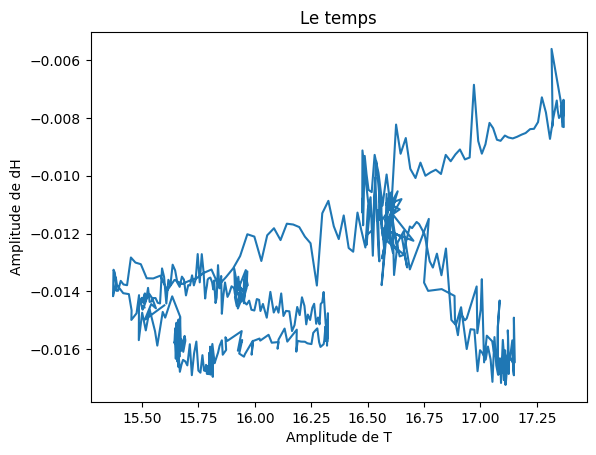

point traité est : 47


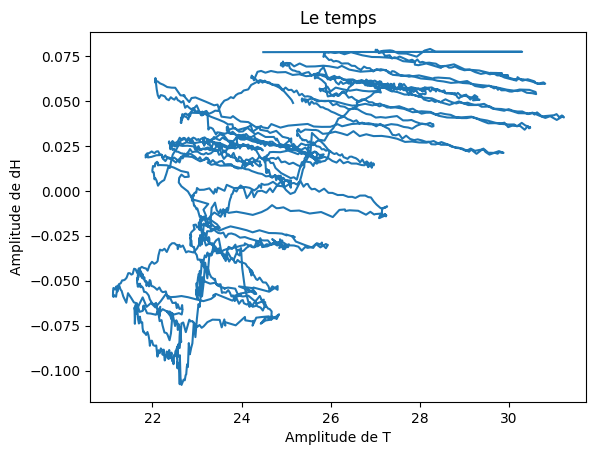

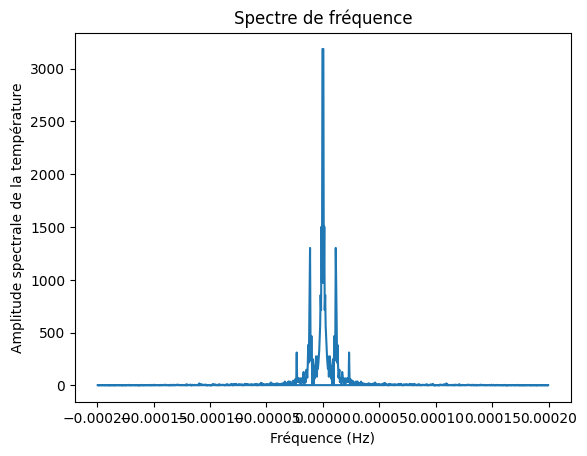

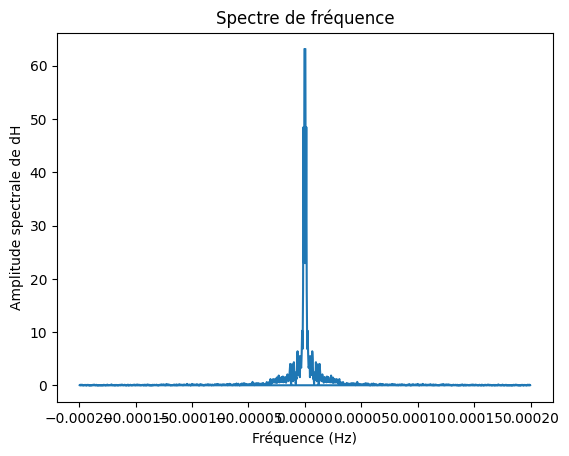

795.1461039540461
[27, 977, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 3, 2, 28, 29, 30, 31, 32, 33, 26, 25, 24, 2704, 1754, 2727, 2726, 2724, 2722, 2721, 2720, 2719, 2718, 2717, 2716, 2715, 2714, 2726, 2724, 2722, 2721, 2720, 2719, 2718, 2717, 2716, 2715, 2714, 2728, 2729, 2703, 2702, 2701, 2700, 2699, 2698, 2705, 2706, 2707]


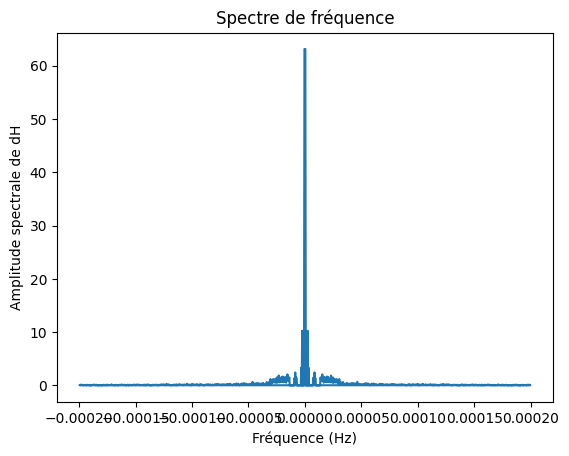

/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


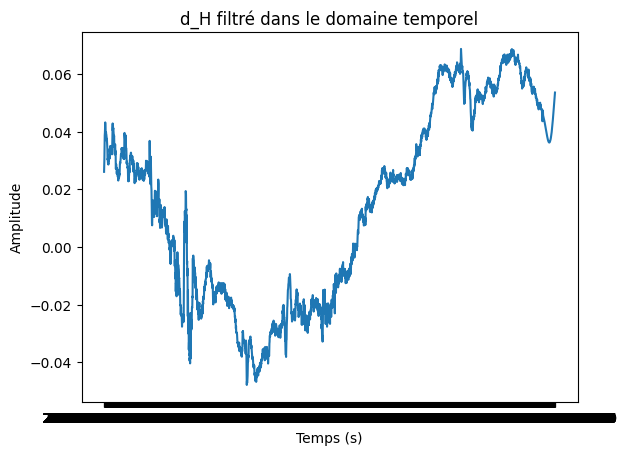

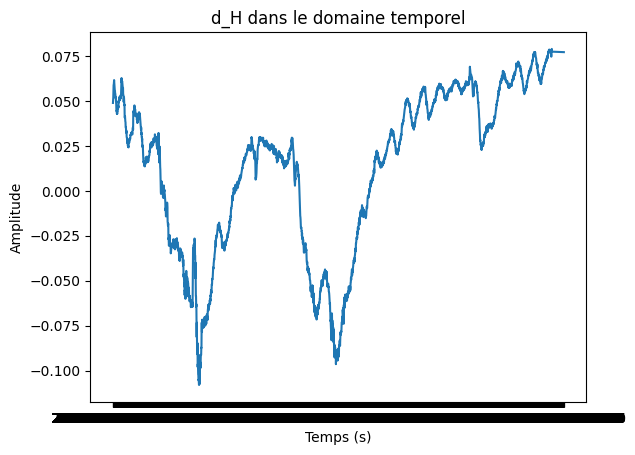

Nouveau coefficient de détermination (R²) : (0.4707785715131366-5.359735070967133e-17j)
point traité est : 13


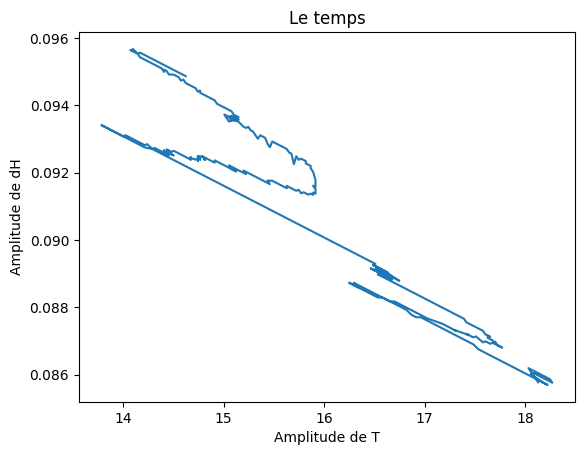

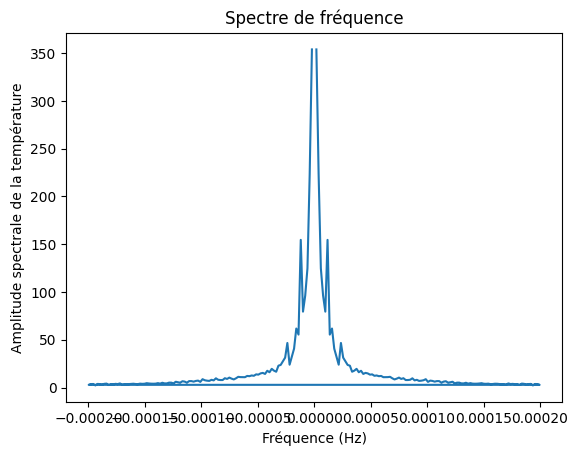

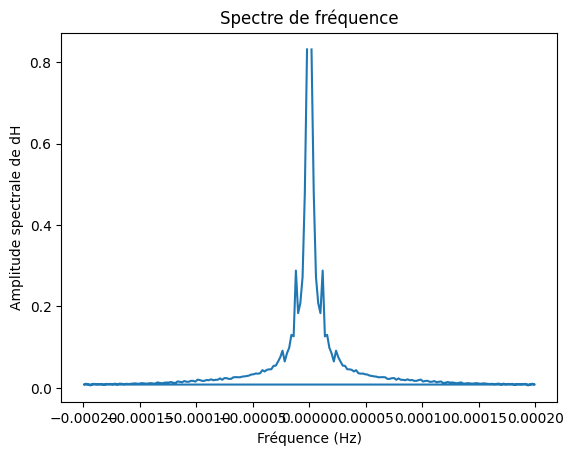

88.47544619879065
[5, 6, 4, 3, 2, 557, 556, 558, 559, 560]


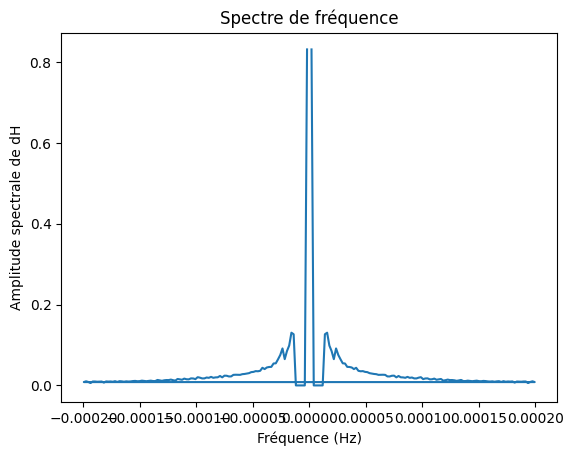

/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


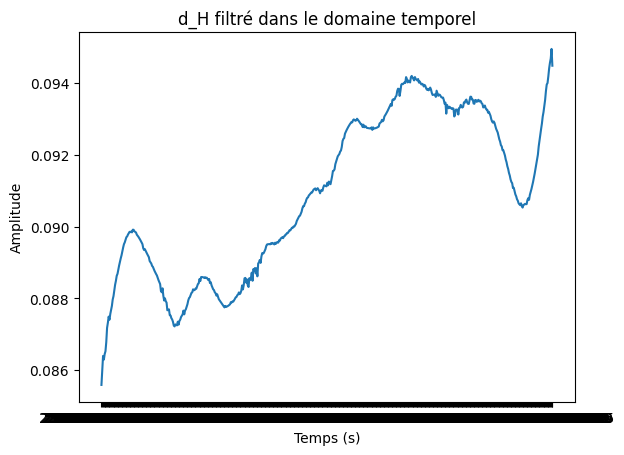

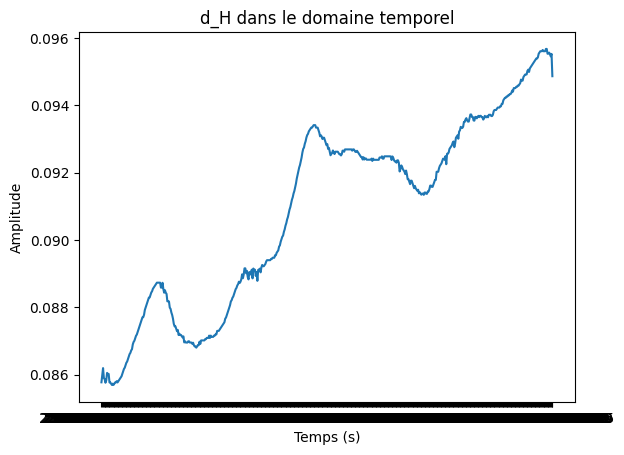

Nouveau coefficient de détermination (R²) : (0.5300333920925407-1.8101597224720815e-17j)
point traité est : 36


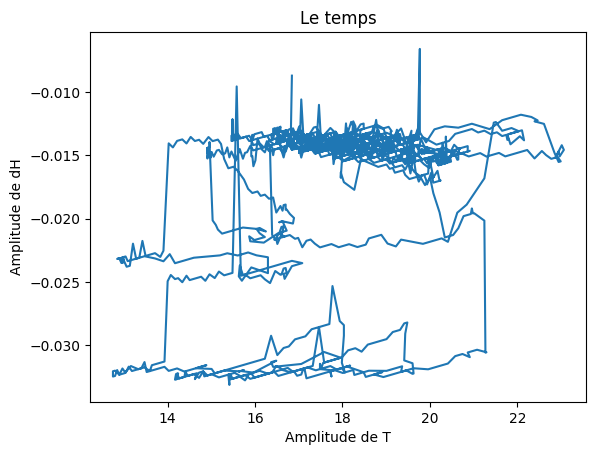

point traité est : 46


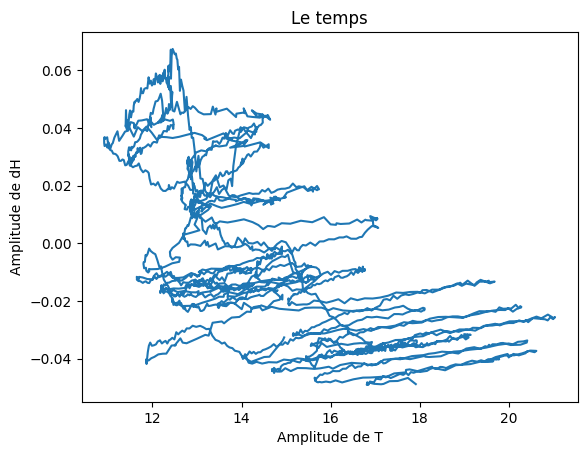

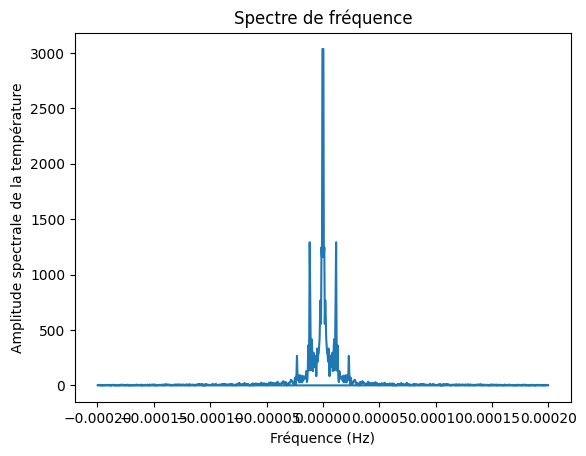

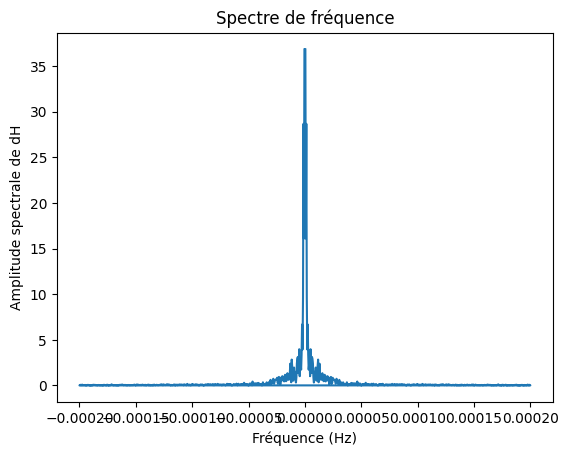

757.9553941961915
[27, 951, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 2, 28, 29, 30, 31, 32, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 2629, 1705, 2652, 2646, 2645, 2644, 2643, 2642, 2641, 2640, 2639, 2638, 2637, 2636, 2635, 2634, 2633, 2632, 2631, 2630, 2629, 2628, 2627, 2626, 2625, 2624, 2651, 2649, 2647, 2646, 2645, 2644, 2643, 2642, 2641, 2640, 2639, 2638, 2637, 2636, 2635, 2634, 2633, 2632, 2631, 2630, 2629, 2628, 2627, 2626, 2625, 2624, 2654, 2628, 2627, 2626, 2625, 2624, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654]


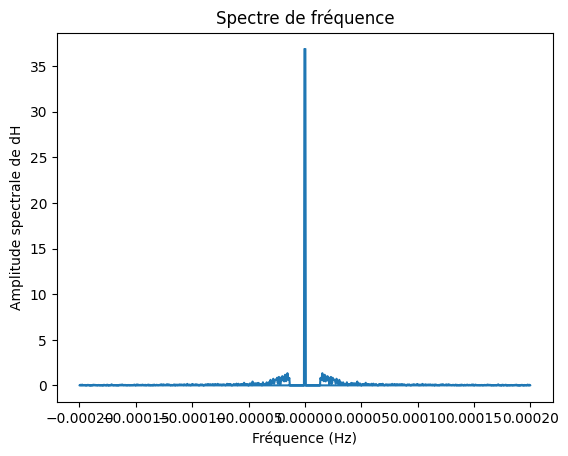

/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


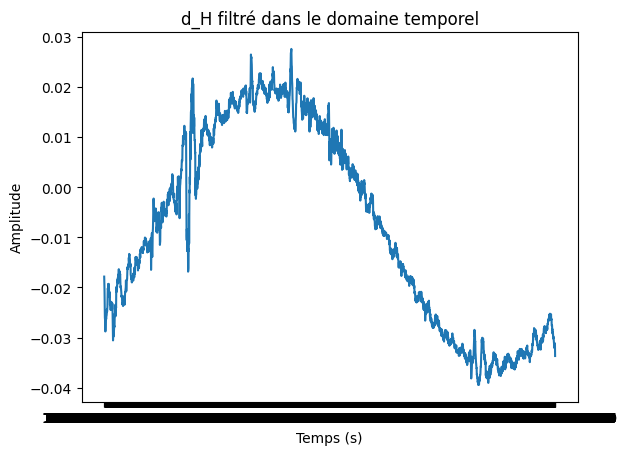

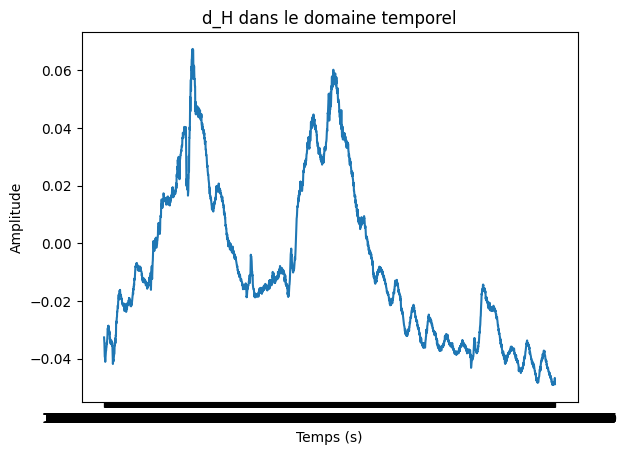

Nouveau coefficient de détermination (R²) : (0.4557751344245294-1.0796145522037037e-17j)
point traité est : 34


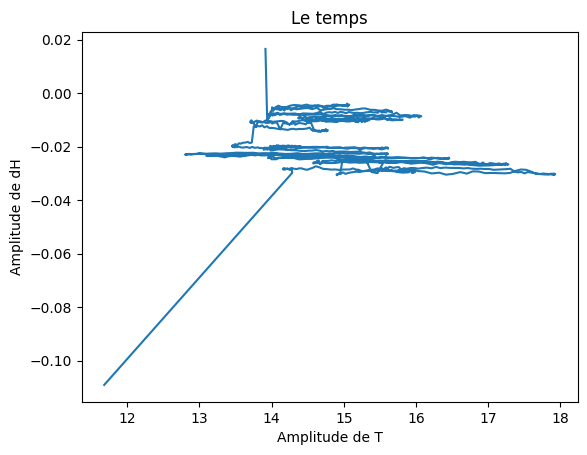

point traité est : 48


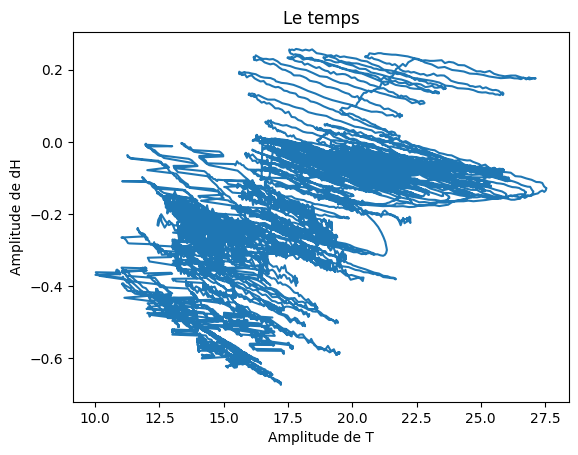

In [90]:
for i in range(len(numeroPoints)) :
    print("point traité est : " + numeroPoints[i])
    traitement(i,data)